# Mount Google Drive

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Importing Essential Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
# Install the Kaggle package using pip
!pip install kaggle

# Download Dataset

In [5]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
from google.colab import files

# Dataset name
dataset_name = 'kmader/skin-cancer-mnist-ham10000'

# Directory to download the dataset
download_dir = '/content/Skin_Cancer/'  # Use the correct directory path in Colab

# Check if the dataset directory already exists
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

# Check if the dataset files already exist
files_in_download_dir = os.listdir(download_dir)

# Check if dataset files are already downloaded
if not any(dataset_name in file for file in files_in_download_dir):
    # Upload the Kaggle API token file
    uploaded = files.upload()

    # Move the uploaded file to the correct location
    for fn in uploaded.keys():
        os.rename(fn, '/root/.kaggle/kaggle.json')

    # Set permissions for the Kaggle API token file
    os.chmod('/root/.kaggle/kaggle.json', 600)

    # Create Kaggle API instance
    api = KaggleApi()
    api.authenticate()  # Make sure you to configure your Kaggle API token

    # Download the dataset
    api.dataset_download_files(dataset_name, path=download_dir, unzip=True)

    print("Dataset downloaded successfully!")
else:
    print("Dataset already exists. Skipping download.")

# List files in the downloaded directory
files_list = os.listdir(download_dir)
print("\nFiles in the downloaded directory:")
print(files_list)


Saving kaggle.json to kaggle.json
Dataset downloaded successfully!

Files in the downloaded directory:
['hmnist_8_8_RGB.csv', 'hmnist_28_28_L.csv', 'hmnist_8_8_L.csv', 'HAM10000_images_part_2', 'ham10000_images_part_2', 'HAM10000_metadata.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_images_part_1', 'ham10000_images_part_1']


# Total Size of files in each directory

In [6]:
import os

# Define the directory paths
directory_path_part_1 = '/content/Skin_Cancer/HAM10000_images_part_1'
directory_path_part_2 = '/content/Skin_Cancer/HAM10000_images_part_2'

# Function to get the total size of files in a directory
def get_directory_size(directory_path):
    try:
        # Get the list of all files in the directory
        files = os.listdir(directory_path)

        # Calculate the total size of files in bytes
        total_size_bytes = sum(os.path.getsize(os.path.join(directory_path, file)) for file in files)

        # Convert bytes to gigabytes
        total_size_GB = total_size_bytes / (1024**3)

        return total_size_GB
    except FileNotFoundError:
        return 0  # Return 0 if the directory is not found

# Get total size of files in each directory
size_part_1_GB = get_directory_size(directory_path_part_1)
size_part_2_GB = get_directory_size(directory_path_part_2)

# Print the results
print(f'Total size of files in HAM10000_images_part_1: {size_part_1_GB:.2f} GB')
print(f'Total size of files in HAM10000_images_part_2: {size_part_2_GB:.2f} GB')

Total size of files in HAM10000_images_part_1: 1.27 GB
Total size of files in HAM10000_images_part_2: 1.31 GB


# Count files in each directory

In [7]:
import os

# Define the directory path
directory_path_part_1 = '/content/Skin_Cancer/HAM10000_images_part_1'
directory_path_part_2 = '/content/Skin_Cancer/HAM10000_images_part_2'

# Function to count files in a directory
def count_files_in_directory(directory_path):
    try:
        # List all files in the directory
        files = os.listdir(directory_path)

        # Count the number of files
        num_files = len(files)

        return num_files
    except FileNotFoundError:
        return 0  # Return 0 if the directory is not found

# Count files in each directory
num_files_part_1 = count_files_in_directory(directory_path_part_1)
num_files_part_2 = count_files_in_directory(directory_path_part_2)

# Print the results
print(f'Number of files in HAM10000_images_part_1: {num_files_part_1}')
print(f'Number of files in HAM10000_images_part_2: {num_files_part_2}')


Number of files in HAM10000_images_part_1: 5000
Number of files in HAM10000_images_part_2: 5015


# Reading Custom metadata.csv
- Upload custom metadata.csv

In [8]:
# Load the custom metadata.csv file
metadata_path = '/content/HAM10000_metadata.csv'
custom_metadata = pd.read_csv(metadata_path)
custom_metadata

,lesion_id,image_id,dx,age,sex,localization
0,HAM_0000118,ISIC_0027419,Normal,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,Normal,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,Normal,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,Normal,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,Normal,75.0,male,ear
...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,Normal,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,Normal,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,Normal,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,Normal,80.0,male,face


In [9]:
# Count the occurrences of unique values in the 'dx' column of the custom_metadata DataFrame
custom_metadata['dx'].value_counts()

Normal    8388
Cancer    1627
Name: dx, dtype: int64

In [10]:
# rename 'dx' column to 'diagnosis'
custom_metadata.rename(columns={'dx': 'diagnosis'}, inplace=True)
custom_metadata

,lesion_id,image_id,diagnosis,age,sex,localization
0,HAM_0000118,ISIC_0027419,Normal,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,Normal,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,Normal,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,Normal,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,Normal,75.0,male,ear
...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,Normal,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,Normal,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,Normal,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,Normal,80.0,male,face


In [11]:
# saving updated metadata.csv
custom_metadata.to_csv("/content/HAM10000_metadata.csv")

# Checking size of images in directory

In [12]:
from PIL import Image
import os

def get_image_size(image_path):
    with Image.open(image_path) as img:
        return img.size

def check_image_sizes(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):  # Assuming images are in JPG format
            image_path = os.path.join(directory, filename)
            size = get_image_size(image_path)
            print(f"Image: {filename}, Size: {size}")

# Replace "path/to/your/directory_1" and "path/to/your/directory_2"
# with the actual paths to your image directories
image_directory_1 = "/content/Skin_Cancer/HAM10000_images_part_1"
image_directory_2 = "/content/Skin_Cancer/HAM10000_images_part_2"

# Check and print image sizes in the first directory
check_image_sizes(image_directory_1)

# Check and print image sizes in the second directory
check_image_sizes(image_directory_2)

Streaming output truncated to the last 5000 lines.
Image: ISIC_0030325.jpg, Size: (600, 450)
Image: ISIC_0033540.jpg, Size: (600, 450)
Image: ISIC_0029582.jpg, Size: (600, 450)
Image: ISIC_0032185.jpg, Size: (600, 450)
Image: ISIC_0030688.jpg, Size: (600, 450)
Image: ISIC_0032548.jpg, Size: (600, 450)
Image: ISIC_0033556.jpg, Size: (600, 450)
Image: ISIC_0033650.jpg, Size: (600, 450)
Image: ISIC_0032356.jpg, Size: (600, 450)
Image: ISIC_0033569.jpg, Size: (600, 450)
Image: ISIC_0033037.jpg, Size: (600, 450)
Image: ISIC_0029719.jpg, Size: (600, 450)
Image: ISIC_0034070.jpg, Size: (600, 450)
Image: ISIC_0031834.jpg, Size: (600, 450)
Image: ISIC_0032162.jpg, Size: (600, 450)
Image: ISIC_0030425.jpg, Size: (600, 450)
Image: ISIC_0029860.jpg, Size: (600, 450)
Image: ISIC_0031547.jpg, Size: (600, 450)
Image: ISIC_0033250.jpg, Size: (600, 450)
Image: ISIC_0030567.jpg, Size: (600, 450)
Image: ISIC_0030174.jpg, Size: (600, 450)
Image: ISIC_0029602.jpg, Size: (600, 450)
Image: ISIC_0030940.jpg, 

# Organizing Normal images in seprate directory

In [16]:
def organize_normal_images(metadata_path, base_dir, target_diagnosis, image_dirs):
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(metadata_path)

    # Check if the target diagnosis directory already exists
    label_dir = os.path.join(base_dir, str(target_diagnosis))
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)
        print(f"Directory for {target_diagnosis} created.")
    else:
        print(f"Directory for {target_diagnosis} already exists.")

    # Iterate through rows and organize images only for the target diagnosis
    for index, row in df.iterrows():
        lesion_id = row['lesion_id']
        image_id = row['image_id']
        diagnosis = row['diagnosis']

        # Check if the current image has the target diagnosis
        if diagnosis == target_diagnosis:
            image_source_path = None

            # Check each image directory for the image
            for image_dir in image_dirs:
                current_image_path = os.path.join(image_dir, f"{image_id}.jpg")

                # Check if the image exists in the current directory
                if os.path.exists(current_image_path):
                    image_source_path = current_image_path
                    break

            # Check if the image exists in any of the source directories
            if image_source_path is not None:
                image_dest_path = os.path.join(label_dir, f"{image_id}.jpg")

                # Check if the image already exists in the destination directory
                if not os.path.exists(image_dest_path):
                    # Copy or move the image to the corresponding label directory
                    # You can use shutil.copy or shutil.move for this
                    # For simplicity, I'll use shutil.copy as an example
                    shutil.copy(image_source_path, image_dest_path)
                    print(f"Image {image_id} copied to {target_diagnosis} directory.")
                else:
                    print(f"Image {image_id} already exists in {target_diagnosis} directory.")
            else:
                print(f"Image {image_id} not found in any source directory.")

    print(f"Directories and images for {target_diagnosis} organized successfully.")

# Example usage:
metadata_path = "/content/HAM10000_metadata.csv"
base_directory = "/content/gdrive/MyDrive/Images"
diagnosis_to_organize = "Normal"
image_directories = ["/content/Skin_Cancer/HAM10000_images_part_1", "/content/Skin_Cancer/HAM10000_images_part_2"]

organize_normal_images(metadata_path, base_directory, diagnosis_to_organize, image_directories)

Streaming output truncated to the last 5000 lines.
Image ISIC_0025770 copied to Normal directory.
Image ISIC_0032224 copied to Normal directory.
Image ISIC_0031264 copied to Normal directory.
Image ISIC_0026639 copied to Normal directory.
Image ISIC_0031979 copied to Normal directory.
Image ISIC_0031680 copied to Normal directory.
Image ISIC_0026917 copied to Normal directory.
Image ISIC_0025207 copied to Normal directory.
Image ISIC_0029738 copied to Normal directory.
Image ISIC_0031627 copied to Normal directory.
Image ISIC_0027804 copied to Normal directory.
Image ISIC_0031828 copied to Normal directory.
Image ISIC_0025395 copied to Normal directory.
Image ISIC_0030304 copied to Normal directory.
Image ISIC_0030982 copied to Normal directory.
Image ISIC_0025445 copied to Normal directory.
Image ISIC_0024509 copied to Normal directory.
Image ISIC_0031419 copied to Normal directory.
Image ISIC_0031949 copied to Normal directory.
Image ISIC_0028996 copied to Normal directory.
Image ISI

# Organizing Cancer images in seprate directory

In [17]:
def organize_cancer_images(metadata_path, base_dir, target_diagnosis, image_dirs):
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(metadata_path)

    # Check if the target diagnosis directory already exists
    label_dir = os.path.join(base_dir, str(target_diagnosis))
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)
        print(f"Directory for {target_diagnosis} created.")
    else:
        print(f"Directory for {target_diagnosis} already exists.")

    # Iterate through rows and organize images only for the target diagnosis
    for index, row in df.iterrows():
        lesion_id = row['lesion_id']
        image_id = row['image_id']
        diagnosis = row['diagnosis']

        # Check if the current image has the target diagnosis
        if diagnosis == target_diagnosis:
            image_source_path = None

            # Check each image directory for the image
            for image_dir in image_dirs:
                current_image_path = os.path.join(image_dir, f"{image_id}.jpg")

                # Check if the image exists in the current directory
                if os.path.exists(current_image_path):
                    image_source_path = current_image_path
                    break

            # Check if the image exists in any of the source directories
            if image_source_path is not None:
                image_dest_path = os.path.join(label_dir, f"{image_id}.jpg")

                # Check if the image already exists in the destination directory
                if not os.path.exists(image_dest_path):
                    # Copy or move the image to the corresponding label directory
                    # You can use shutil.copy or shutil.move for this
                    # For simplicity, I'll use shutil.copy as an example
                    shutil.copy(image_source_path, image_dest_path)
                    print(f"Image {image_id} copied to {target_diagnosis} directory.")
                else:
                    print(f"Image {image_id} already exists in {target_diagnosis} directory.")
            else:
                print(f"Image {image_id} not found in any source directory.")

    print(f"Directories and images for {target_diagnosis} organized successfully.")

# Example usage:
metadata_path = "/content/HAM10000_metadata.csv"
base_directory = "/content/gdrive/MyDrive/Images"
diagnosis_to_organize = "Cancer"
image_directories = ["/content/Skin_Cancer/HAM10000_images_part_1", "/content/Skin_Cancer/HAM10000_images_part_2"]

organize_cancer_images(metadata_path, base_directory, diagnosis_to_organize, image_directories)

Directory for Cancer created.
Image ISIC_0025964 copied to Cancer directory.
Image ISIC_0030623 copied to Cancer directory.
Image ISIC_0027190 copied to Cancer directory.
Image ISIC_0031023 copied to Cancer directory.
Image ISIC_0028086 copied to Cancer directory.
Image ISIC_0031177 copied to Cancer directory.
Image ISIC_0026993 copied to Cancer directory.
Image ISIC_0026120 copied to Cancer directory.
Image ISIC_0028412 copied to Cancer directory.
Image ISIC_0030417 copied to Cancer directory.
Image ISIC_0026531 copied to Cancer directory.
Image ISIC_0032396 copied to Cancer directory.
Image ISIC_0030443 copied to Cancer directory.
Image ISIC_0031499 copied to Cancer directory.
Image ISIC_0025450 copied to Cancer directory.
Image ISIC_0024586 copied to Cancer directory.
Image ISIC_0025451 copied to Cancer directory.
Image ISIC_0032248 copied to Cancer directory.
Image ISIC_0028445 copied to Cancer directory.
Image ISIC_0027076 copied to Cancer directory.
Image ISIC_0029512 copied to C

# Augmenting and visualizing an image from cancer directory

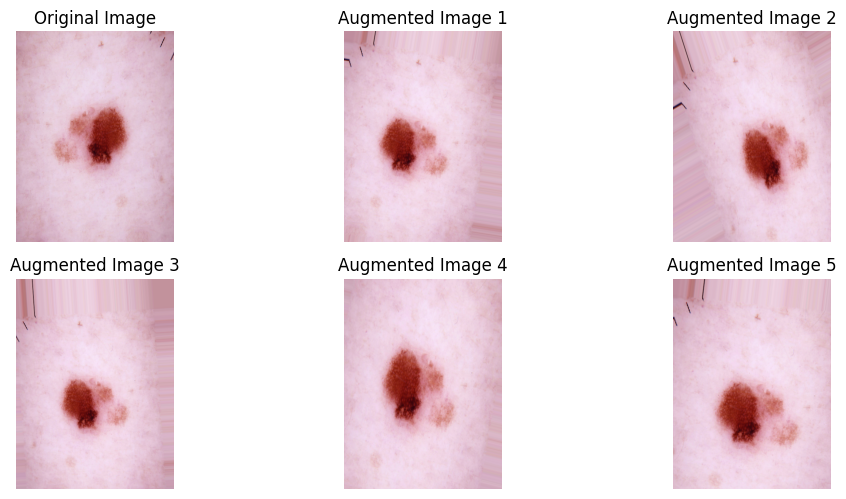

In [19]:
def augment_and_visualize_single_image(image_path, target_size=(600, 450), num_augmented_images=5):
    # Load the single image
    img = image.load_img(image_path, target_size=target_size)

    # Convert the image to a numpy array
    x = image.img_to_array(img)

    # Reshape the image to (1, height, width, channels) as required by the flow() method
    x = np.expand_dims(x, axis=0)

    # Create an instance of the ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Generate augmented images and visualize them
    plt.figure(figsize=(10, 15))

    # Display the original image
    plt.subplot(num_augmented_images + 1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    # Display augmented images
    for i, batch in enumerate(datagen.flow(x, batch_size=1), start=2):
        plt.subplot(num_augmented_images + 1, 3, i)
        plt.imshow(image.array_to_img(batch[0]))
        plt.title(f'Augmented Image {i-1}')
        plt.axis('off')
        if i > (num_augmented_images):  # Display the specified number of augmented images
            break

    plt.tight_layout()
    plt.show()

# Path to the directory containing the single image
image_dir = "/content/gdrive/MyDrive/Images/Cancer"

# Specify the image file name
image_file = "ISIC_0024313.jpg"

# Full path to the image
image_path = os.path.join(image_dir, image_file)

# Call the function to augment and visualize a single image
augment_and_visualize_single_image(image_path)

# Augmenting all images in cancer directory

In [20]:
def augment_images(original_image_dir, augmented_image_dir, target_size=(600, 450), num_augmented_images=4):
    """
    Augment images in the original directory and save the augmented images in the output directory.

    Parameters:
    - original_image_dir (str): Path to the directory containing original images.
    - augmented_image_dir (str): Path to the directory where augmented images will be saved.
    - target_size (tuple): Target size for the images (height, width).
    - num_augmented_images (int): Number of augmented images to generate per original image.

    Returns:
    - None
    """
    # Create the output directory if it doesn't exist
    if not os.path.exists(augmented_image_dir):
        os.makedirs(augmented_image_dir)

    # Create an instance of the ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Get the list of image files in the original directory
    image_files = [f for f in os.listdir(original_image_dir) if f.endswith('.jpg')]

    # Iterate through each image file and apply augmentation
    for img_file in image_files:
        # Get the image ID from the file name
        image_id = os.path.splitext(img_file)[0]

        print(f"Augmenting images for: {image_id}")

        # Load the image
        img_path = os.path.join(original_image_dir, img_file)
        img = image.load_img(img_path, target_size=target_size)

        # Convert the image to a numpy array
        x = image.img_to_array(img)

        # Reshape the image to (1, height, width, channels) as required by the flow() method
        x = np.expand_dims(x, axis=0)

        # Generate augmented images and save them to the output directory
        for i in range(1, num_augmented_images + 1):
            batch = next(datagen.flow(x, batch_size=1))
            augmented_image_path = os.path.join(augmented_image_dir, f'{image_id}_aug_{i}.jpg')
            image.save_img(augmented_image_path, batch[0])
            print(f"Saved augmented image {i}/{num_augmented_images}: {augmented_image_path}")

        print(f"Augmentation complete for: {image_id}")
        print(f"Original Image: {image_id}.jpg, Augmented Images: {num_augmented_images}")

# Example usage:
original_image_directory = "/content/gdrive/MyDrive/Images/Cancer"
augmented_image_directory = "/content/gdrive/MyDrive/Images/Aug_Cancer"
augment_images(original_image_directory, augmented_image_directory, target_size=(600, 450), num_augmented_images=4)

Streaming output truncated to the last 5000 lines.
Augmentation complete for: ISIC_0025391
Original Image: ISIC_0025391.jpg, Augmented Images: 4
Augmenting images for: ISIC_0025413
Saved augmented image 1/4: /content/gdrive/MyDrive/Images/Aug_Cancer/ISIC_0025413_aug_1.jpg
Saved augmented image 2/4: /content/gdrive/MyDrive/Images/Aug_Cancer/ISIC_0025413_aug_2.jpg
Saved augmented image 3/4: /content/gdrive/MyDrive/Images/Aug_Cancer/ISIC_0025413_aug_3.jpg
Saved augmented image 4/4: /content/gdrive/MyDrive/Images/Aug_Cancer/ISIC_0025413_aug_4.jpg
Augmentation complete for: ISIC_0025413
Original Image: ISIC_0025413.jpg, Augmented Images: 4
Augmenting images for: ISIC_0032192
Saved augmented image 1/4: /content/gdrive/MyDrive/Images/Aug_Cancer/ISIC_0032192_aug_1.jpg
Saved augmented image 2/4: /content/gdrive/MyDrive/Images/Aug_Cancer/ISIC_0032192_aug_2.jpg
Saved augmented image 3/4: /content/gdrive/MyDrive/Images/Aug_Cancer/ISIC_0032192_aug_3.jpg
Saved augmented image 4/4: /content/gdrive/My

# Count the number of files in Cancer directory

In [21]:
import os

# Define the directory path
directory_path_part_1 = '/content/gdrive/MyDrive/Images/Cancer'

# Function to count files in a directory
def count_files_in_directory(directory_path):
    try:
        # List all files in the directory
        files = os.listdir(directory_path)

        # Count the number of files
        num_files = len(files)

        return num_files
    except FileNotFoundError:
        return 0  # Return 0 if the directory is not found

# Count files in each directory
num_files_part_1 = count_files_in_directory(directory_path_part_1)

# Print the results
print(f'Number of files in Cancer: {num_files_part_1}')

Number of files in Cancer: 1627


# Count the number of files in Aug_Cancer directory

In [22]:
import os

# Define the directory path
directory_path_part_1 = '/content/gdrive/MyDrive/Images/Aug_Cancer'

# Function to count files in a directory
def count_files_in_directory(directory_path):
    try:
        # List all files in the directory
        files = os.listdir(directory_path)

        # Count the number of files
        num_files = len(files)

        return num_files
    except FileNotFoundError:
        return 0  # Return 0 if the directory is not found

# Count files in each directory
num_files_part_1 = count_files_in_directory(directory_path_part_1)

# Print the results
print(f'Number of files in Aug_Cancer: {num_files_part_1}')

Number of files in Aug_Cancer: 6508


# Count the number of files in Normal directory

In [23]:
import os

# Define the directory path
directory_path_part_1 = '/content/gdrive/MyDrive/Images/Normal'

# Function to count files in a directory
def count_files_in_directory(directory_path):
    try:
        # List all files in the directory
        files = os.listdir(directory_path)

        # Count the number of files
        num_files = len(files)

        return num_files
    except FileNotFoundError:
        return 0  # Return 0 if the directory is not found

# Count files in each directory
num_files_part_1 = count_files_in_directory(directory_path_part_1)

# Print the results
print(f'Number of files in Normal: {num_files_part_1}')

Number of files in Normal: 8388


# Combined metadata.csv (Normal + Cancer + Aug_Cancer)

In [25]:
import os
import pandas as pd

def create_augmented_metadata(original_metadata_path, augmented_image_dir, output_metadata_path):
    # Load the original metadata
    original_metadata = pd.read_csv(original_metadata_path)

    # Get the list of image files in the augmented directory
    augmented_image_files = [f for f in os.listdir(augmented_image_dir) if f.endswith('.jpg')]

    # Create a new DataFrame to store augmented metadata
    augmented_metadata = pd.DataFrame(columns=original_metadata.columns)

    for augmented_image_file in augmented_image_files:
        # Extract information from the augmented image filename
        file_parts = os.path.splitext(augmented_image_file)[0].split('_')
        original_image_id = '_'.join(file_parts[:-2])  # Extract the original image ID
        augmentation_number = int(file_parts[-1])  # Extract the augmentation number

        # Find the corresponding row in the original metadata
        original_row = original_metadata[original_metadata['image_id'] == original_image_id]

        # Check if the original image is present in the original metadata
        if not original_row.empty:
            # Create a new row for the augmented image
            augmented_row = original_row.copy()
            augmented_row['image_id'] = f"{original_image_id}_aug_{augmentation_number}"
            augmented_row['file_path'] = os.path.join(augmented_image_dir, augmented_image_file)

            # Append the augmented row to the new metadata
            augmented_metadata = pd.concat([augmented_metadata, augmented_row], ignore_index=True)

    # Concatenate the original and augmented metadata
    combined_metadata = pd.concat([original_metadata, augmented_metadata], ignore_index=True)

    # Save the combined metadata to a new CSV file
    combined_metadata.to_csv(output_metadata_path, index=False)
    print(f"Combined metadata saved to {output_metadata_path}")

# Example usage:
original_metadata_path = "/content/HAM10000_metadata.csv"
augmented_image_directory = "/content/gdrive/MyDrive/Images/Aug_Cancer"
output_metadata_path = "/content/gdrive/MyDrive/Images/Aug_HAM10000_metadata.csv"

create_augmented_metadata(original_metadata_path, augmented_image_directory, output_metadata_path)

Combined metadata saved to /content/gdrive/MyDrive/Images/Aug_HAM10000_metadata.csv


# Reading Combined metadata.csv

In [26]:
df = pd.read_csv('/content/gdrive/MyDrive/Images/Aug_HAM10000_metadata.csv')
df

,Unnamed: 0,lesion_id,image_id,diagnosis,age,sex,localization,file_path
0,0,HAM_0000118,ISIC_0027419,Normal,80.0,male,scalp,NaN
1,1,HAM_0000118,ISIC_0025030,Normal,80.0,male,scalp,NaN
2,2,HAM_0002730,ISIC_0026769,Normal,80.0,male,scalp,NaN
3,3,HAM_0002730,ISIC_0025661,Normal,80.0,male,scalp,NaN
4,4,HAM_0001466,ISIC_0031633,Normal,75.0,male,ear,NaN
...,...,...,...,...,...,...,...,...
16518,8834,HAM_0002552,ISIC_0033232_aug_4,Cancer,25.0,male,upper extremity,/content/gdrive/MyDrive/Images/Aug_Cancer/ISIC...
16519,10014,HAM_0003521,ISIC_0032258_aug_1,Cancer,70.0,female,back,/content/gdrive/MyDrive/Images/Aug_Cancer/ISIC...
16520,10014,HAM_0003521,ISIC_0032258_aug_2,Cancer,70.0,female,back,/content/gdrive/MyDrive/Images/Aug_Cancer/ISIC...
16521,10014,HAM_0003521,ISIC_0032258_aug_3,Cancer,70.0,female,back,/content/gdrive/MyDrive/Images/Aug_Cancer/ISIC...


In [27]:
# dropping "unnamed: 0" column from dataframe
df.drop(columns=['Unnamed: 0', 'file_path'], inplace=True)
df

,lesion_id,image_id,diagnosis,age,sex,localization
0,HAM_0000118,ISIC_0027419,Normal,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,Normal,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,Normal,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,Normal,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,Normal,75.0,male,ear
...,...,...,...,...,...,...
16518,HAM_0002552,ISIC_0033232_aug_4,Cancer,25.0,male,upper extremity
16519,HAM_0003521,ISIC_0032258_aug_1,Cancer,70.0,female,back
16520,HAM_0003521,ISIC_0032258_aug_2,Cancer,70.0,female,back
16521,HAM_0003521,ISIC_0032258_aug_3,Cancer,70.0,female,back


In [28]:
# Count the occurrences of each unique value in the 'diagnosis' column of the DataFrame
df['diagnosis'].value_counts()

Normal    8388
Cancer    8135
Name: diagnosis, dtype: int64

# Feature Extraction ( Gray_scale image of 8*8 size)

In [29]:
from skimage import io, color, transform

def extract_features_and_save(image_dir_normal, image_dir_cancer, image_dir_aug_cancer, custom_metadata_path, features_csv_path):
    """
    Extract features from images in three directories (Normal, Cancer, Aug_Cancer) based on custom metadata and save to CSV.

    Parameters:
    - image_dir_normal (str): Path to the directory containing Normal images.
    - image_dir_cancer (str): Path to the directory containing Cancer images.
    - image_dir_aug_cancer (str): Path to the directory containing Aug_Cancer images.
    - custom_metadata_path (str): Path to the custom metadata CSV file.
    - features_csv_path (str): Path to save the extracted features CSV file.

    Returns:
    - None
    """
    # Load custom metadata
    custom_metadata = pd.read_csv(custom_metadata_path)

    # Initialize an empty DataFrame to store features
    features_df = pd.DataFrame()

    # Check if the features CSV file already exists
    if os.path.exists(features_csv_path):
        print("Features CSV file already exists. Skipping feature extraction.")
        return
    else:
        # Loop through each row in the custom metadata
        for index, row in custom_metadata.iterrows():
            lesion_id = row['lesion_id']
            image_id = row['image_id']

            # Construct the full path to the image file
            if os.path.exists(os.path.join(image_dir_normal, f"{image_id}.jpg")):
                image_path = os.path.join(image_dir_normal, f"{image_id}.jpg")
            elif os.path.exists(os.path.join(image_dir_cancer, f"{image_id}.jpg")):
                image_path = os.path.join(image_dir_cancer, f"{image_id}.jpg")
            elif os.path.exists(os.path.join(image_dir_aug_cancer, f"{image_id}.jpg")):
                image_path = os.path.join(image_dir_aug_cancer, f"{image_id}.jpg")
            else:
                print(f"Image not found for {image_id}. Skipping.")
                continue

            # Read and resize the image to 8x8 pixels in grayscale
            image = io.imread(image_path)
            image_gray = color.rgb2gray(image)
            image_resized = transform.resize(image_gray, (8, 8), anti_aliasing=True)

            # Flatten the pixel values and create a DataFrame row
            features_row = pd.DataFrame(image_resized.flatten()).transpose()

            # Normalize pixel values to the range [0, 1]
            normalized_features = (features_row - features_row.min().min()) / (features_row.max().max() - features_row.min().min())

            # Include 'image_id' and 'lesion_id' in the features DataFrame
            normalized_features['image_id'] = image_id
            normalized_features['lesion_id'] = lesion_id

            # Append the row to the features DataFrame
            features_df = pd.concat([features_df, normalized_features], ignore_index=True)

        # Save the features DataFrame to a CSV file
        features_df.to_csv(features_csv_path, index=False)
        print(f"Features saved to {features_csv_path}")

# Example usage:
image_dir_normal = '/content/gdrive/MyDrive/Images/Normal'
image_dir_cancer = '/content/gdrive/MyDrive/Images/Cancer'
image_dir_aug_cancer = '/content/gdrive/MyDrive/Images/Aug_Cancer'
custom_metadata_path = '/content/gdrive/MyDrive/Images/Aug_HAM10000_metadata.csv'
features_csv_path = '/content/gdrive/MyDrive/Images/Aug_HAM_8_8_custom_features_normalized.csv'

extract_features_and_save(image_dir_normal, image_dir_cancer, image_dir_aug_cancer, custom_metadata_path, features_csv_path)

Features CSV file already exists. Skipping feature extraction.


# Loading features.csv

In [30]:
# Load your features CSV file
features_path = '/content/gdrive/MyDrive/Images/Aug_HAM_8_8_custom_features_normalized.csv'
features_df = pd.read_csv(features_path)
features_df

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,image_id,lesion_id
0,0.362525,0.552011,0.700388,0.562363,0.500827,0.462800,0.242420,0.212483,0.380833,0.695641,...,0.352595,0.556581,0.889522,0.774436,0.605390,0.514335,0.317166,0.130496,ISIC_0027419,HAM_0000118
1,0.213094,0.562749,0.738689,0.858989,0.812301,0.696959,0.633339,0.257653,0.468670,0.722821,...,0.151549,0.605631,0.818755,0.857484,0.884962,0.789438,0.508068,0.000000,ISIC_0025030,HAM_0000118
2,0.314948,0.349545,0.567544,0.426858,0.163901,0.298139,0.339202,0.000000,0.410216,0.538625,...,0.131455,0.468360,0.746477,0.869718,0.870419,0.617584,0.397326,0.040510,ISIC_0026769,HAM_0002730
3,0.384494,0.701408,0.793985,0.801822,0.769866,0.753710,0.680544,0.310063,0.596467,0.781057,...,0.210035,0.619606,0.796815,0.810997,0.764589,0.700452,0.524048,0.000000,ISIC_0025661,HAM_0002730
4,0.418254,0.590735,0.649672,0.621683,0.715350,0.989346,0.993962,0.705932,0.408010,0.206432,...,0.316528,0.603976,0.668174,0.674803,0.691707,0.699890,0.636095,0.517081,ISIC_0031633,HAM_0001466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16518,0.958452,0.938404,0.916876,0.911490,0.882429,0.872206,0.865642,0.845113,0.875760,0.786730,...,0.896320,0.875305,0.906567,0.951462,0.983081,1.000000,0.971821,0.912527,ISIC_0034134_aug_4,HAM_0006184
16519,0.247905,0.215933,0.423742,0.614449,0.632645,0.480187,0.659509,0.817991,0.428416,0.459121,...,0.869250,0.862586,0.832590,0.772031,0.711007,0.343537,0.000000,0.009384,ISIC_0033878_aug_1,HAM_0003351
16520,0.283543,0.498523,0.565852,0.334646,0.226373,0.353655,0.410328,0.508783,0.373226,0.436807,...,0.000000,0.554463,0.771076,0.872169,0.840796,0.777508,0.712544,0.397670,ISIC_0033878_aug_2,HAM_0003351
16521,0.000000,0.169207,0.466549,0.631767,0.694501,0.655159,0.754643,0.810275,0.215692,0.465880,...,0.700746,0.749337,0.936527,0.991102,0.993457,0.944893,0.875873,0.825026,ISIC_0033878_aug_3,HAM_0003351


In [31]:
# Merge metadata with features based on common columns, e.g., 'image_id', 'lesion_id'.
merged_data = pd.merge(df, features_df, on=['lesion_id', 'image_id'])
merged_data

,lesion_id,image_id,diagnosis,age,sex,localization,0,1,2,3,...,54,55,56,57,58,59,60,61,62,63
0,HAM_0000118,ISIC_0027419,Normal,80.0,male,scalp,0.362525,0.552011,0.700388,0.562363,...,0.303623,0.177692,0.352595,0.556581,0.889522,0.774436,0.605390,0.514335,0.317166,0.130496
1,HAM_0000118,ISIC_0025030,Normal,80.0,male,scalp,0.213094,0.562749,0.738689,0.858989,...,0.672509,0.442991,0.151549,0.605631,0.818755,0.857484,0.884962,0.789438,0.508068,0.000000
2,HAM_0002730,ISIC_0026769,Normal,80.0,male,scalp,0.314948,0.349545,0.567544,0.426858,...,0.580511,0.403992,0.131455,0.468360,0.746477,0.869718,0.870419,0.617584,0.397326,0.040510
3,HAM_0002730,ISIC_0025661,Normal,80.0,male,scalp,0.384494,0.701408,0.793985,0.801822,...,0.690972,0.338256,0.210035,0.619606,0.796815,0.810997,0.764589,0.700452,0.524048,0.000000
4,HAM_0001466,ISIC_0031633,Normal,75.0,male,ear,0.418254,0.590735,0.649672,0.621683,...,0.736811,0.845363,0.316528,0.603976,0.668174,0.674803,0.691707,0.699890,0.636095,0.517081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16518,HAM_0002552,ISIC_0033232_aug_4,Cancer,25.0,male,upper extremity,1.000000,0.967726,0.961462,0.939095,...,0.857559,0.855864,0.885003,0.869244,0.850632,0.868323,0.895355,0.941723,0.922310,0.902893
16519,HAM_0003521,ISIC_0032258_aug_1,Cancer,70.0,female,back,0.935609,0.852525,0.820167,0.865797,...,0.928587,0.933865,0.762243,0.614945,0.070196,0.539369,0.948386,0.906583,0.964114,1.000000
16520,HAM_0003521,ISIC_0032258_aug_2,Cancer,70.0,female,back,0.789628,0.834111,0.930583,0.968487,...,0.687951,0.714474,0.910958,0.936194,0.933361,0.960842,0.617199,0.027531,0.609366,0.748903
16521,HAM_0003521,ISIC_0032258_aug_3,Cancer,70.0,female,back,0.862321,0.884018,0.892388,0.890277,...,0.511760,0.779520,0.848381,1.000000,0.993375,0.941436,0.847126,0.000000,0.509820,0.771950


In [32]:
# checking column names
merged_data.columns

Index(['lesion_id', 'image_id', 'diagnosis', 'age', 'sex', 'localization', '0',
       '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',
       '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49',
       '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61',
       '62', '63'],
      dtype='object')

In [33]:
# dropping age, sex and localization column
merged_data = merged_data.drop(['age', 'sex', 'localization'], axis=1)
merged_data

,lesion_id,image_id,diagnosis,0,1,2,3,4,5,6,...,54,55,56,57,58,59,60,61,62,63
0,HAM_0000118,ISIC_0027419,Normal,0.362525,0.552011,0.700388,0.562363,0.500827,0.462800,0.242420,...,0.303623,0.177692,0.352595,0.556581,0.889522,0.774436,0.605390,0.514335,0.317166,0.130496
1,HAM_0000118,ISIC_0025030,Normal,0.213094,0.562749,0.738689,0.858989,0.812301,0.696959,0.633339,...,0.672509,0.442991,0.151549,0.605631,0.818755,0.857484,0.884962,0.789438,0.508068,0.000000
2,HAM_0002730,ISIC_0026769,Normal,0.314948,0.349545,0.567544,0.426858,0.163901,0.298139,0.339202,...,0.580511,0.403992,0.131455,0.468360,0.746477,0.869718,0.870419,0.617584,0.397326,0.040510
3,HAM_0002730,ISIC_0025661,Normal,0.384494,0.701408,0.793985,0.801822,0.769866,0.753710,0.680544,...,0.690972,0.338256,0.210035,0.619606,0.796815,0.810997,0.764589,0.700452,0.524048,0.000000
4,HAM_0001466,ISIC_0031633,Normal,0.418254,0.590735,0.649672,0.621683,0.715350,0.989346,0.993962,...,0.736811,0.845363,0.316528,0.603976,0.668174,0.674803,0.691707,0.699890,0.636095,0.517081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16518,HAM_0002552,ISIC_0033232_aug_4,Cancer,1.000000,0.967726,0.961462,0.939095,0.927355,0.902175,0.878227,...,0.857559,0.855864,0.885003,0.869244,0.850632,0.868323,0.895355,0.941723,0.922310,0.902893
16519,HAM_0003521,ISIC_0032258_aug_1,Cancer,0.935609,0.852525,0.820167,0.865797,0.844785,0.862222,0.825128,...,0.928587,0.933865,0.762243,0.614945,0.070196,0.539369,0.948386,0.906583,0.964114,1.000000
16520,HAM_0003521,ISIC_0032258_aug_2,Cancer,0.789628,0.834111,0.930583,0.968487,0.913781,0.992151,0.999533,...,0.687951,0.714474,0.910958,0.936194,0.933361,0.960842,0.617199,0.027531,0.609366,0.748903
16521,HAM_0003521,ISIC_0032258_aug_3,Cancer,0.862321,0.884018,0.892388,0.890277,0.942598,0.986825,0.949813,...,0.511760,0.779520,0.848381,1.000000,0.993375,0.941436,0.847126,0.000000,0.509820,0.771950


In [34]:
# checking dtype of diagnosis column
merged_data['diagnosis'].dtype

dtype('O')

In [35]:
# value counts of diagnosis column
merged_data['diagnosis'].value_counts()

Normal    8388
Cancer    8135
Name: diagnosis, dtype: int64

In [36]:
# Convert the column to string type
merged_data['diagnosis'] = merged_data['diagnosis'].astype(str)

# Label Encoding

In [37]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the 'diagnosis' column
merged_data['diagnosis_label'] = label_encoder.fit_transform(merged_data['diagnosis'])

# Swap the labels
merged_data['diagnosis_label'] = 1 - merged_data['diagnosis_label']

# Display the updated DataFrame
merged_data[['diagnosis', 'diagnosis_label']]

,diagnosis,diagnosis_label
0,Normal,0
1,Normal,0
2,Normal,0
3,Normal,0
4,Normal,0
...,...,...
16518,Cancer,1
16519,Cancer,1
16520,Cancer,1
16521,Cancer,1


In [38]:
merged_data

,lesion_id,image_id,diagnosis,0,1,2,3,4,5,6,...,55,56,57,58,59,60,61,62,63,diagnosis_label
0,HAM_0000118,ISIC_0027419,Normal,0.362525,0.552011,0.700388,0.562363,0.500827,0.462800,0.242420,...,0.177692,0.352595,0.556581,0.889522,0.774436,0.605390,0.514335,0.317166,0.130496,0
1,HAM_0000118,ISIC_0025030,Normal,0.213094,0.562749,0.738689,0.858989,0.812301,0.696959,0.633339,...,0.442991,0.151549,0.605631,0.818755,0.857484,0.884962,0.789438,0.508068,0.000000,0
2,HAM_0002730,ISIC_0026769,Normal,0.314948,0.349545,0.567544,0.426858,0.163901,0.298139,0.339202,...,0.403992,0.131455,0.468360,0.746477,0.869718,0.870419,0.617584,0.397326,0.040510,0
3,HAM_0002730,ISIC_0025661,Normal,0.384494,0.701408,0.793985,0.801822,0.769866,0.753710,0.680544,...,0.338256,0.210035,0.619606,0.796815,0.810997,0.764589,0.700452,0.524048,0.000000,0
4,HAM_0001466,ISIC_0031633,Normal,0.418254,0.590735,0.649672,0.621683,0.715350,0.989346,0.993962,...,0.845363,0.316528,0.603976,0.668174,0.674803,0.691707,0.699890,0.636095,0.517081,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16518,HAM_0002552,ISIC_0033232_aug_4,Cancer,1.000000,0.967726,0.961462,0.939095,0.927355,0.902175,0.878227,...,0.855864,0.885003,0.869244,0.850632,0.868323,0.895355,0.941723,0.922310,0.902893,1
16519,HAM_0003521,ISIC_0032258_aug_1,Cancer,0.935609,0.852525,0.820167,0.865797,0.844785,0.862222,0.825128,...,0.933865,0.762243,0.614945,0.070196,0.539369,0.948386,0.906583,0.964114,1.000000,1
16520,HAM_0003521,ISIC_0032258_aug_2,Cancer,0.789628,0.834111,0.930583,0.968487,0.913781,0.992151,0.999533,...,0.714474,0.910958,0.936194,0.933361,0.960842,0.617199,0.027531,0.609366,0.748903,1
16521,HAM_0003521,ISIC_0032258_aug_3,Cancer,0.862321,0.884018,0.892388,0.890277,0.942598,0.986825,0.949813,...,0.779520,0.848381,1.000000,0.993375,0.941436,0.847126,0.000000,0.509820,0.771950,1


# train_test_split

In [39]:
from sklearn.model_selection import train_test_split

# Shuffle the data
shuffled_data = merged_data.sample(frac=1, random_state=42)

# Split the shuffled data into features (X) and labels (y)
X = shuffled_data.drop(['lesion_id', 'image_id', 'diagnosis', 'diagnosis_label'], axis=1)
y = shuffled_data['diagnosis_label']

# Split the shuffled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
X   # checking input features

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
6096,1.000000,0.832610,0.587379,0.717924,0.845558,0.990352,0.931682,0.762740,0.793354,0.540030,...,0.856346,0.819335,0.519815,0.418851,0.545900,0.730108,0.933655,0.989337,0.880436,0.843838
6834,0.332843,0.596523,0.648113,0.714048,0.768551,0.845125,0.812277,0.533966,0.236912,0.554015,...,0.876214,0.921622,0.208486,0.000000,0.578540,0.914126,0.714242,0.653817,0.789807,0.880908
6281,1.000000,0.885562,0.927249,0.818309,0.853689,0.873153,0.797089,0.757070,0.904050,0.852530,...,0.706570,0.721759,0.789426,0.843693,0.878796,0.855371,0.752556,0.700311,0.599200,0.633182
11631,0.862845,0.917809,0.775959,0.338501,0.323703,0.720408,0.857780,0.828500,0.864441,0.874358,...,0.892420,0.901160,0.673263,0.684428,0.702654,0.745014,0.839076,0.882312,0.896401,0.891441
4533,0.779466,0.766887,0.830440,0.934419,1.000000,0.988788,0.915311,0.794705,0.788538,0.825013,...,0.720704,0.679261,0.667844,0.712003,0.711032,0.732148,0.740841,0.738595,0.746064,0.640115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.086462,0.600591,0.810833,0.905365,0.886364,0.871242,0.784717,0.602833,0.246989,0.580024,...,0.779180,0.745744,0.613291,0.586293,0.574247,0.627377,0.714367,0.802814,0.747569,0.722805
11964,0.748544,0.859133,0.922874,0.849328,0.731260,0.852896,0.939113,0.986495,0.821882,0.914360,...,0.778983,0.722076,0.878618,0.849005,0.744921,0.639190,0.760700,0.855881,0.786662,0.723659
5390,0.832164,0.867957,0.948471,0.930589,0.946942,0.944469,0.916206,0.807866,0.859453,0.900414,...,0.912785,0.844109,0.695529,0.793182,0.873400,0.942375,0.936716,0.930645,0.896086,0.838808
860,0.000000,0.611289,0.902800,0.921708,0.853007,0.747128,0.629084,0.198926,0.324168,0.847735,...,0.950736,0.778002,0.410326,0.727059,0.616696,0.712929,0.944203,1.000000,0.894872,0.592702


In [41]:
y   # checking target feature column

6096     0
6834     0
6281     0
11631    1
4533     0
        ..
11284    1
11964    1
5390     0
860      0
15795    1
Name: diagnosis_label, Length: 16523, dtype: int64

In [42]:
# Check if any value is outside the [0, 1] range
out_of_range_values = X[(X < 0) | (X > 1)].stack()

# If there are any out-of-range values, display them
if not out_of_range_values.empty:
    print("Out-of-range values found:")
    print(out_of_range_values)
else:
    print("No values outside the [0, 1] range. Data is already normalized")

No values outside the [0, 1] range. Data is already normalized


# Fitting 4 different ml models

In [47]:
# Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict(X_test)

# SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)

# Decision Tree
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Evaluate the models
models = {'Naive Bayes': nb_predictions, 'SVM': svm_predictions, 'Decision Tree': dt_predictions, 'Random Forest': rf_predictions}

for model_name, predictions in models.items():
    accuracy = accuracy_score(y_test, predictions)
    confusion = confusion_matrix(y_test, predictions)
    classification_rep = classification_report(y_test, predictions)

    print(f"\n\nModel: {model_name}")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(confusion)
    print("Classification Report:")
    print(classification_rep)



Model: Naive Bayes
Accuracy: 0.6989409984871406
Confusion Matrix:
[[1273  386]
 [ 609 1037]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.77      0.72      1659
           1       0.73      0.63      0.68      1646

    accuracy                           0.70      3305
   macro avg       0.70      0.70      0.70      3305
weighted avg       0.70      0.70      0.70      3305



Model: SVM
Accuracy: 0.8090771558245083
Confusion Matrix:
[[1485  174]
 [ 457 1189]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.90      0.82      1659
           1       0.87      0.72      0.79      1646

    accuracy                           0.81      3305
   macro avg       0.82      0.81      0.81      3305
weighted avg       0.82      0.81      0.81      3305



Model: Decision Tree
Accuracy: 0.6928895612708018
Confusion Matrix:
[[1161  498]
 [ 517 1129]]
Classification Report

# heatmap confusion matrix for each model



Model: Naive Bayes
Accuracy: 0.6989409984871406
Confusion Matrix:
[[1273  386]
 [ 609 1037]]


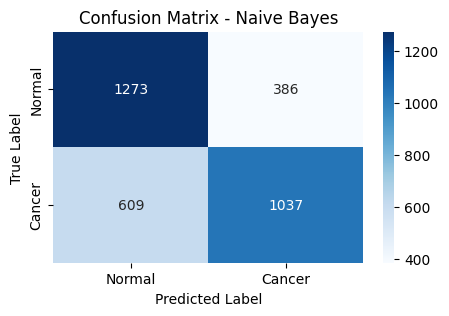



Model: SVM
Accuracy: 0.8090771558245083
Confusion Matrix:
[[1485  174]
 [ 457 1189]]


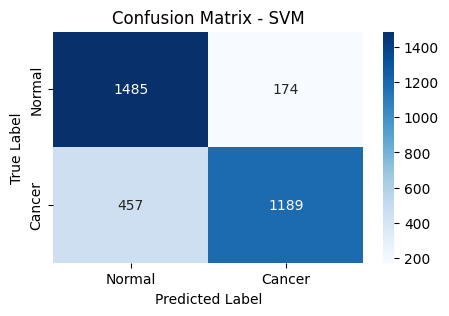



Model: Decision Tree
Accuracy: 0.6928895612708018
Confusion Matrix:
[[1161  498]
 [ 517 1129]]


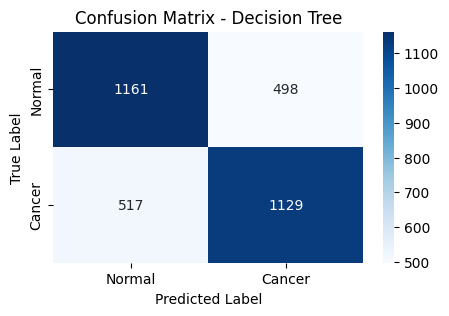



Model: Random Forest
Accuracy: 0.7957639939485628
Confusion Matrix:
[[1393  266]
 [ 409 1237]]


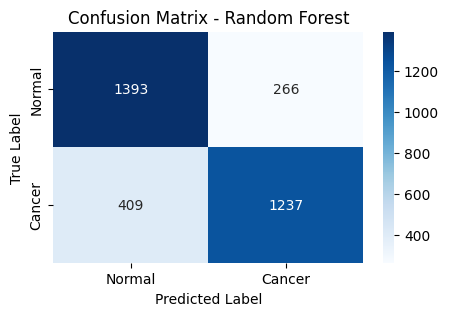

In [48]:
# Create a heatmap for each model
for model_name, predictions in models.items():
    accuracy = accuracy_score(y_test, predictions)
    confusion = confusion_matrix(y_test, predictions)

    print(f"\n\nModel: {model_name}")
    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(confusion)

    # Plotting the heatmap
    plt.figure(figsize=(5, 3))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Cancer'], yticklabels=['Normal', 'Cancer'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Visualization

### ROC curve for different models

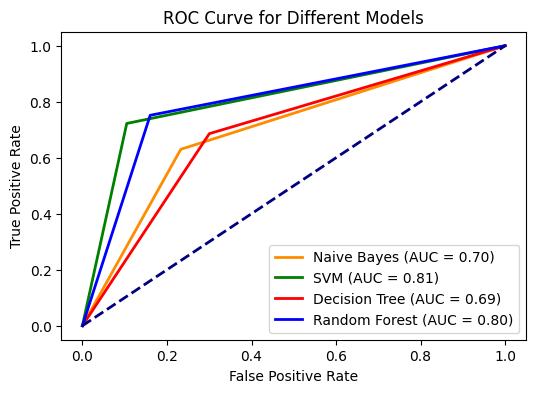

In [49]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have predictions for each model: nb_predictions, svm_predictions, dt_predictions, rf_predictions
# Replace them with the actual predictions from your models

# Compute ROC curve and ROC area for each class
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_predictions)
roc_auc_nb = auc(fpr_nb, tpr_nb)

fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_predictions)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_predictions)
roc_auc_dt = auc(fpr_dt, tpr_dt)

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_predictions)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curves
plt.figure(figsize=(6, 4))
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label='Naive Bayes (AUC = %0.2f)' % roc_auc_nb)
plt.plot(fpr_svm, tpr_svm, color='green', lw=2, label='SVM (AUC = %0.2f)' % roc_auc_svm)
plt.plot(fpr_dt, tpr_dt, color='red', lw=2, label='Decision Tree (AUC = %0.2f)' % roc_auc_dt)
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Models')
plt.legend(loc="lower right")
plt.savefig('ROC Curve for Different Models.png')
plt.show()

In [50]:
from sklearn.metrics import roc_auc_score

# Print ROC AUC Score
for model_name, predictions in models.items():
    auc_score = roc_auc_score(y_test, predictions)
    print(f"The ROC AUC score for {model_name} is: {auc_score:.2f}")

The ROC AUC score for Naive Bayes is: 0.70
The ROC AUC score for SVM is: 0.81
The ROC AUC score for Decision Tree is: 0.69
The ROC AUC score for Random Forest is: 0.80


# Plot Precision-Recall curves

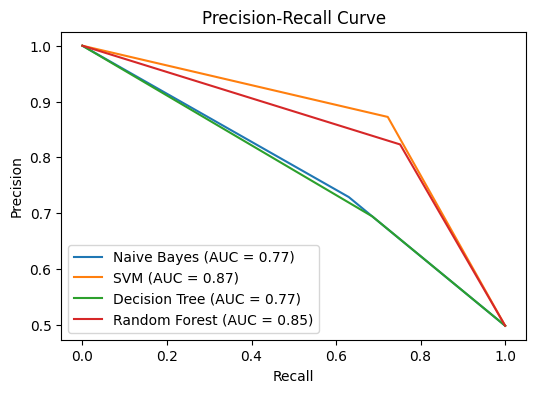

In [51]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Plot Precision-Recall Curve
plt.figure(figsize=(6, 4))

for model_name, predictions in models.items():
    precision, recall, _ = precision_recall_curve(y_test, predictions)
    auc_score = auc(recall, precision)

    plt.plot(recall, precision, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.savefig('Plot Precision-Recall Curve.png')
plt.show()

# Precision, Recall, F1 Score

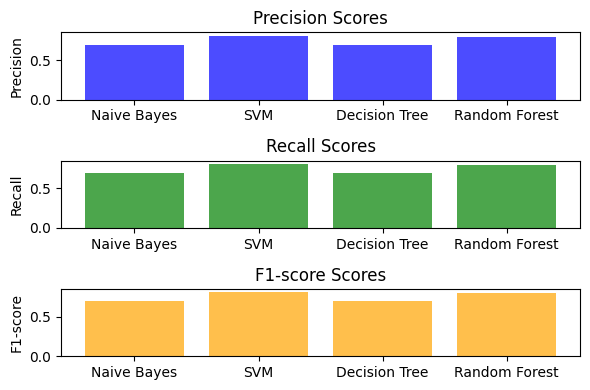

In [52]:
from sklearn.metrics import precision_recall_fscore_support

# Initialize lists to store metric scores
precision_scores = []
recall_scores = []
f1_scores = []

model_names = list(models.keys())

for model_name, predictions in models.items():
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average='weighted')
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Plot bar charts
fig, ax = plt.subplots(3, 1, figsize=(6, 4))

# Precision
ax[0].bar(model_names, precision_scores, color='blue', alpha=0.7)
ax[0].set_ylabel('Precision')
ax[0].set_title('Precision Scores')

# Recall
ax[1].bar(model_names, recall_scores, color='green', alpha=0.7)
ax[1].set_ylabel('Recall')
ax[1].set_title('Recall Scores')

# F1-score
ax[2].bar(model_names, f1_scores, color='orange', alpha=0.7)
ax[2].set_ylabel('F1-score')
ax[2].set_title('F1-score Scores')

plt.tight_layout()
plt.savefig('precision_recall_fscore_support.png')
plt.show()

# Model Comparison - Accuracy Scores

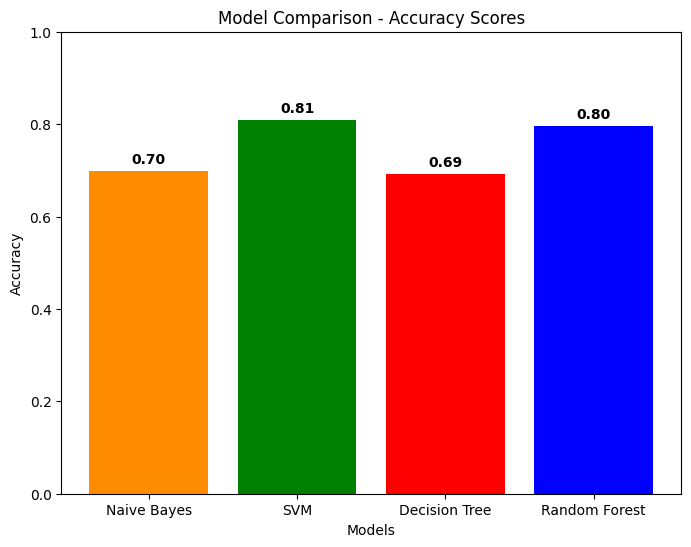

In [53]:
# Calculate accuracy scores for each model
accuracy_nb = accuracy_score(y_test, nb_predictions)
accuracy_svm = accuracy_score(y_test, svm_predictions)
accuracy_dt = accuracy_score(y_test, dt_predictions)
accuracy_rf = accuracy_score(y_test, rf_predictions)

# Plot a bar chart with exact accuracy values using matplotlib
model_names = ['Naive Bayes', 'SVM', 'Decision Tree', 'Random Forest']
accuracy_scores = [accuracy_nb, accuracy_svm, accuracy_dt, accuracy_rf]

plt.figure(figsize=(8, 6))
for i, acc in enumerate(accuracy_scores):
    plt.text(i, acc + 0.01, f'{acc:.2f}', ha='center', va='bottom', fontweight='bold')

plt.bar(model_names, accuracy_scores, color=['darkorange', 'green', 'red', 'blue'])
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison - Accuracy Scores')
plt.savefig('Model Comparison - Accuracy Scores.png')
plt.show()

# Model's Accuracy in Plotly Library

In [54]:
import plotly.io as pio
import plotly.express as px

# Calculate accuracy scores for each model
accuracy_nb = accuracy_score(y_test, nb_predictions)
accuracy_svm = accuracy_score(y_test, svm_predictions)
accuracy_dt = accuracy_score(y_test, dt_predictions)
accuracy_rf = accuracy_score(y_test, rf_predictions)

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Models': ['Naive Bayes', 'SVM', 'Decision Tree', 'Random Forest'],
    'Accuracy': [accuracy_nb, accuracy_svm, accuracy_dt, accuracy_rf]
})

# Plot with plotly express
fig = px.bar(df, x='Models', y='Accuracy', text='Accuracy', color='Models',
             labels={'Accuracy': 'Accuracy'},
             title='Model Comparison - Accuracy Scores',
             hover_data=['Accuracy'],
             template='plotly_white',
             color_discrete_map={'Naive Bayes': 'purple', 'SVM': 'green', 'Decision Tree': 'red', 'Random Forest': 'blue'},
             width=1000, height=700)

# Update layout to add hover effects
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')

# Show the plot
fig.show()